In [2]:
import os
import torch 
import random
import torch.nn as nn
import torchvision
import torchvision.models as models
from torch.autograd import Function
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

In [3]:
class GradientReversalFn(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        # Store context for backprop
        ctx.alpha = alpha
        
        # Forward pass is a no-op
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        # Backward pass is just to -alpha the gradient
        output = grad_output.neg() * ctx.alpha

        # Must return same number as inputs to forward()
        return output, None

In [4]:
class DACNN(nn.Module):
    def __init__(self, c):
        super().__init__()
        self.feature_extractor = nn.Sequential(
                                                nn.Conv2d(1, c, 3, padding=1),
                                                nn.BatchNorm2d(c),
                                                nn.LeakyReLU(),
                                                nn.MaxPool2d(2),
                                                nn.Conv2d(c, 2*c, 3, padding=1),
                                                nn.BatchNorm2d(2*c),
                                                nn.LeakyReLU(),
                                                nn.MaxPool2d(2),
                                                nn.Conv2d(2*c, 4*c, 3, padding=1),
                                                nn.BatchNorm2d(4*c),
                                                nn.LeakyReLU(),
                                                nn.MaxPool2d(2),
                                                nn.Conv2d(4*c, 8*c, 3, padding=1),
                                                nn.BatchNorm2d(8*c),
                                                nn.LeakyReLU(),
                                                nn.Flatten()
                                            )

        self.class_classifier = nn.Sequential(
                                                nn.Linear(216, 64),
                                                nn.LeakyReLU(),
                                                nn.Linear(64, 2),
#                                                 nn.LogSoftmax(dim=1),
                                            )
        
        self.domain_classifier = nn.Sequential(
                                                nn.Linear(216, 64),
                                                nn.LeakyReLU(),
                                                nn.Linear(64, 2),
#                                                 nn.LogSoftmax(dim=1),
                                            )

    def forward(self, x, grl_lambda=1.0):
        
        features = self.feature_extractor(x)
        reverse_features = GradientReversalFn.apply(features, grl_lambda)
        class_pred = self.class_classifier(features)
        domain_pred = self.domain_classifier(reverse_features)
        
        return class_pred, domain_pred

In [5]:
class myData(Dataset):
    def __init__(self, pathToImgs, tranformation=None, distrib='source'):
        
        self.distrib = distrib
        self.pathToImgs = pathToImgs
        self.transforms = tranformation
        
        if self.distrib == 'source':
            data = os.listdir(pathToImgs)
            random.shuffle(data)
            self.imgNames = data
            self.transfrom = transforms.Compose([
                                            transforms.Resize((28,28)),
                                            transforms.CenterCrop((24,24)),
                                            transforms.ToTensor(),
                                            transforms.Normalize(mean = (0.34144994450215727,),
                                                                 std  = (0.06782956562805965,)),
                                               ])
    
        elif self.distrib == 'target':
            self.imgNames = os.listdir(pathToImgs)
            self.transfrom = transforms.Compose([transforms.ToTensor(),
                                                 transforms.Normalize(mean = (0.4982371738336079,),
                                                                      std  = (0.13347655994299062,)),
                                                ])


    def __len__(self):
        return len(self.imgNames)
    
    def __getitem__(self, idx):
      
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = os.path.join(self.pathToImgs, self.imgNames[idx])
       
        
        if self.distrib == 'target':
            label = self.imgNames[idx].split('.')[0]
            label = torch.tensor(int(label.split('_')[1]))
            image = Image.open(img_name) 
            image = self.transfrom(image)
            
        elif self.distrib == 'source':
            image = Image.open(img_name) 
            image = self.transfrom(image)
            label = torch.tensor(int(self.imgNames[idx].split('_')[4]))
            
        return image, label

In [6]:
# ds_source = myData(path_target, 'target')
# ds_target = myData(path_target, distrib='target')

# mean = 0
# std = 0
# for i in ds_target: 
#     data = np.array(i[0])
#     mean += np.mean(data)
#     std  += np.std(data)
# mean/len(ds_source), std/len(ds_source)

In [14]:
path_source_train = './mrlEyes_2018_01/train/'
path_source_test =  './mrlEyes_2018_01/test/'
path_target_train = './EyesDataset/train/'
path_target_test = './EyesDataset/test/'

bsize = 200
ds_source_train = myData(path_source_train)
ds_target_train = myData(path_target_train, distrib='target')
ds_source_test = myData(path_source_test)
ds_target_test = myData(path_target_test, distrib='target')

dl_source_train = DataLoader(ds_source_train, batch_size= bsize, shuffle=True)
dl_target_train = DataLoader(ds_target_train, batch_size= bsize, shuffle=True)
dl_source_test = DataLoader(ds_source_test, batch_size= bsize)
dl_target_test = DataLoader(ds_target_test, batch_size= bsize)

In [15]:
max_batches = min(len(dl_source_train), len(dl_target_train))
max_batches

19

In [20]:
lr = 1e-3
n_epochs = 10

# Setup optimizer as usual
model = DACNN(c=3)
optimizer = torch.optim.Adam(model.parameters(), lr)

# Two losses functions this time
loss_fn_class = nn.CrossEntropyLoss()
loss_fn_domain =  nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss()

In [21]:
def get_accuracy(model, loader):
    model.eval()
    correct = 0 
    with torch.no_grad():
        for batch in loader: 
            x, y = batch[0], batch[1]
            out = model(x)
            preds = torch.argmax(out[0], dim=1)
            correct += torch.mean((preds == y).float()).item()
    correct /= len(loader)
    return correct

In [22]:

for epoch_idx in range(n_epochs):
    print(f'Epoch {epoch_idx+1:04d} / {n_epochs:04d}', end='\n=================\n')
    dl_source_iter = iter(dl_source_train)
    dl_target_iter = iter(dl_target_train)
    model.train()
    
    for batch_idx in range(max_batches):
        optimizer.zero_grad()
        # Training progress and GRL lambda
        p = float(batch_idx + epoch_idx * max_batches) / (n_epochs * max_batches)
        grl_lambda = 2. / (1. + np.exp(-10 * p)) - 1

        # Train on source domain
        X_s, y_s = next(dl_source_iter)
        y_s_domain = torch.zeros(X_s.shape[0], dtype=torch.long) # generate source domain labels

        class_pred, domain_pred = model(X_s, grl_lambda)
        loss_s_label = loss_fn_class(class_pred, y_s)
        loss_s_domain = loss_fn_domain(domain_pred, y_s_domain)

        # Train on target domain
        X_t, _ = next(dl_target_iter) # ignore target domain class labels!
        y_t_domain = torch.ones(X_t.shape[0], dtype=torch.long) # generate target domain labels

        _, domain_pred = model(X_t, grl_lambda)
        loss_t_domain = loss_fn_domain(domain_pred, y_t_domain)
        
        loss = loss_t_domain + loss_s_domain + loss_s_label
        loss.backward()
        optimizer.step()
        
        print(f'[{batch_idx+1}/{max_batches}] '
              f'class_loss: {loss_s_label.item():.4f} ' f's_domain_loss: {loss_s_domain.item():.4f} '
              f't_domain_loss: {loss_t_domain.item():.4f} ' f'grl_lambda: {grl_lambda:.3f} '
             )
    acc_train_sc =  get_accuracy(model, dl_source_train)
    acc_test_sc = get_accuracy(model, dl_source_test)
    acc_train_tg =  get_accuracy(model, dl_target_train)
    acc_test_tg = get_accuracy(model, dl_target_test)
    print(f'[{batch_idx+1}/{max_batches}] '
          f' source_acc_train: {acc_train_sc:.4f}' f' source_acc_test: {acc_test_sc:.4f}')
    print(f'[{batch_idx+1}/{max_batches}] '
          f' target_acc_train: {acc_train_tg:.4f}' f' target_acc_test: {acc_test_tg:.4f}')

Epoch 0001 / 0010
[1/19] class_loss: 0.6959 s_domain_loss: 0.6634 t_domain_loss: 0.7333 grl_lambda: 0.000 
[2/19] class_loss: 0.6826 s_domain_loss: 0.7035 t_domain_loss: 0.6609 grl_lambda: 0.026 
[3/19] class_loss: 0.6493 s_domain_loss: 0.7325 t_domain_loss: 0.6120 grl_lambda: 0.053 
[4/19] class_loss: 0.6273 s_domain_loss: 0.7344 t_domain_loss: 0.5819 grl_lambda: 0.079 
[5/19] class_loss: 0.6359 s_domain_loss: 0.7330 t_domain_loss: 0.5734 grl_lambda: 0.105 
[6/19] class_loss: 0.5987 s_domain_loss: 0.7330 t_domain_loss: 0.5310 grl_lambda: 0.131 
[7/19] class_loss: 0.6057 s_domain_loss: 0.7159 t_domain_loss: 0.5348 grl_lambda: 0.157 
[8/19] class_loss: 0.5596 s_domain_loss: 0.6982 t_domain_loss: 0.5337 grl_lambda: 0.182 
[9/19] class_loss: 0.5779 s_domain_loss: 0.6785 t_domain_loss: 0.5302 grl_lambda: 0.207 
[10/19] class_loss: 0.5321 s_domain_loss: 0.6728 t_domain_loss: 0.5064 grl_lambda: 0.233 
[11/19] class_loss: 0.5293 s_domain_loss: 0.6407 t_domain_loss: 0.5067 grl_lambda: 0.257 
[

[10/19] class_loss: 0.3120 s_domain_loss: 0.6301 t_domain_loss: 0.6606 grl_lambda: 0.977 
[11/19] class_loss: 0.2740 s_domain_loss: 0.6004 t_domain_loss: 0.6629 grl_lambda: 0.979 
[12/19] class_loss: 0.2710 s_domain_loss: 0.6442 t_domain_loss: 0.6291 grl_lambda: 0.980 
[13/19] class_loss: 0.2564 s_domain_loss: 0.6324 t_domain_loss: 0.6571 grl_lambda: 0.981 
[14/19] class_loss: 0.2523 s_domain_loss: 0.5946 t_domain_loss: 0.7026 grl_lambda: 0.982 
[15/19] class_loss: 0.2822 s_domain_loss: 0.6049 t_domain_loss: 0.7063 grl_lambda: 0.983 
[16/19] class_loss: 0.2802 s_domain_loss: 0.6199 t_domain_loss: 0.6848 grl_lambda: 0.984 
[17/19] class_loss: 0.3094 s_domain_loss: 0.6302 t_domain_loss: 0.7095 grl_lambda: 0.984 
[18/19] class_loss: 0.2899 s_domain_loss: 0.6410 t_domain_loss: 0.7422 grl_lambda: 0.985 
[19/19] class_loss: 0.3056 s_domain_loss: 0.6490 t_domain_loss: 0.6889 grl_lambda: 0.986 
[19/19]  source_acc_train: 0.8344 source_acc_test: 0.6290
[19/19]  target_acc_train: 0.4576 target_a

[19/19] class_loss: 0.2071 s_domain_loss: 0.7340 t_domain_loss: 0.7031 grl_lambda: 1.000 
[19/19]  source_acc_train: 0.8908 source_acc_test: 0.6469
[19/19]  target_acc_train: 0.5092 target_acc_test: 0.4750
Epoch 0010 / 0010
[1/19] class_loss: 0.3020 s_domain_loss: 0.7290 t_domain_loss: 0.7566 grl_lambda: 1.000 
[2/19] class_loss: 0.2499 s_domain_loss: 0.6912 t_domain_loss: 0.6960 grl_lambda: 1.000 
[3/19] class_loss: 0.2583 s_domain_loss: 0.6895 t_domain_loss: 0.7253 grl_lambda: 1.000 
[4/19] class_loss: 0.2328 s_domain_loss: 0.6712 t_domain_loss: 0.7445 grl_lambda: 1.000 
[5/19] class_loss: 0.2640 s_domain_loss: 0.6799 t_domain_loss: 0.7824 grl_lambda: 1.000 
[6/19] class_loss: 0.1637 s_domain_loss: 0.6716 t_domain_loss: 0.7805 grl_lambda: 1.000 
[7/19] class_loss: 0.2553 s_domain_loss: 0.6623 t_domain_loss: 0.7962 grl_lambda: 1.000 
[8/19] class_loss: 0.2563 s_domain_loss: 0.6651 t_domain_loss: 0.7593 grl_lambda: 1.000 
[9/19] class_loss: 0.2580 s_domain_loss: 0.6967 t_domain_loss: 0

In [152]:
embedding_source = np.empty((len(dl_source)*bsize, 216))
embedding_target = np.empty((len(dl_target)*bsize, 216))

In [154]:
model.eval()
for j, i in enumerate(dl_source):
  dim = i[0].shape[0]
  with torch.no_grad():
      embedding_source[j*dim:j*dim+dim,:] = model.feature_extractor(i[0]).numpy()

In [68]:
from sklearn.manifold import TSNE as tsne

In [155]:
s_emb_tsne = tsne(n_components=2).fit_transform(embedding_source)

In [156]:
t_emb_tsne = tsne(n_components=2).fit_transform(embedding_target)

In [76]:
import matplotlib.pyplot as plt

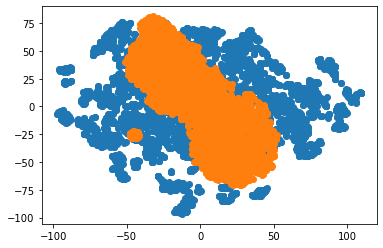

In [157]:
plt.scatter(s_emb_tsne[:,0], s_emb_tsne[:,1])
plt.scatter(t_emb_tsne[:,0], t_emb_tsne[:,1])

In [41]:
plt.scatter(s_emb_tsne[:,0], s_emb_tsne[:,1])
plt.scatter(t_emb_tsne[:,0], t_emb_tsne[:,1])

NameError: name 's_emb_tsne' is not defined